### Import The Necessary Libraries

In [9]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer
from transformers import T5EncoderModel, T5Tokenizer, CLIPTokenizer, CLIPTextModel
from tqdm import tqdm


### Load The Data

In [10]:
# Load the datasets
stimuli = [line.strip() for line in open('data/stimuli.txt').readlines()]
subj1 = np.load('data/subj1.npy', allow_pickle=True).item()
subj2 = np.load('data/subj2.npy', allow_pickle=True).item()
subjects = {'subj1': subj1, 'subj2': subj2}
ROIs = ['language', 'vision', 'task', 'dmn']

# Load embedding models
print("Loading embedding models...")
sbert_model1 = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model2 = SentenceTransformer('all-mpnet-base-v2')
t5_model = T5EncoderModel.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
clip_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')


Loading embedding models...


### Generate The Embeddings

In [11]:
# Generate embeddings functions
def get_t5_embeddings(sentences):
    inputs = t5_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = t5_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def get_clip_embeddings(sentences):
    inputs = clip_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Generate all embeddings
print("Generating embeddings...")
sbert_embeddings1 = sbert_model1.encode(stimuli, show_progress_bar=True)
sbert_embeddings2 = sbert_model2.encode(stimuli, show_progress_bar=True)
t5_embeddings = get_t5_embeddings(stimuli)
clip_embeddings = get_clip_embeddings(stimuli)


Generating embeddings...


Batches: 100%|██████████| 20/20 [00:01<00:00, 14.07it/s]


In [12]:

# Store embeddings in a dictionary
embeddings = {
    'SBERT1': sbert_embeddings1,
    'SBERT2': sbert_embeddings2,
    'T5': t5_embeddings,
    'CLIP': clip_embeddings
}

### Compute Evaluation Metrics

In [ ]:
def cosine_distance(u, v):
    return 1 - cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0][0]

def v2v_accuracy(y_true, y_pred):
    """
    Calculate the 2-vs-2 accuracy as defined in the assignment.
    """
    N = len(y_true)
    correct = 0
    
    for i in range(N-1):
        for j in range(i+1, N):
            # Calculate the matching score (same indices)
            score_match = (cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0] + 
                         cosine_similarity(y_true[j].reshape(1, -1), y_pred[j].reshape(1, -1))[0][0])
            
            # Calculate the non-matching score (crossed indices)
            score_non_match = (cosine_similarity(y_true[i].reshape(1, -1), y_pred[j].reshape(1, -1))[0][0] + 
                             cosine_similarity(y_true[j].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0])
            
            # Check if matching score is higher than non-matching
            if score_match > score_non_match:
                correct += 1
                
    total_pairs = (N * (N - 1)) // 2
    return correct / total_pairs

def pearson_corr(y_true, y_pred):
    """
    Calculate the average Pearson correlation across all dimensions.
    """
    return np.mean([pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])])

def rank_accuracy(y_true, y_pred, database):
    """
    Calculate the median rank of the true sentence among all database sentences based on cosine similarity.

    Parameters:
    - y_true: Ground truth embeddings (numpy array of shape [n_samples, embedding_dim]).
    - y_pred: Predicted embeddings (numpy array of shape [n_samples, embedding_dim]).
    - database: Database of all embeddings to compare against (numpy array of shape [n_database, embedding_dim]).

    Returns:
    - Median rank (float): The median rank of the true sentence across all samples. Lower is better.

    Description:
    For each predicted embedding, this function computes the cosine similarity with all database embeddings.
    It then determines the rank of the true sentence (based on its similarity score) among all database sentences.
    The rank is 1-indexed, meaning the best possible rank is 1 (highest similarity).
    Finally, the function returns the median rank across all samples.
    """
    n_samples = y_true.shape[0]
    ranks = []
    
    for i in range(n_samples):
        # Calculate cosine similarity between predicted and all database embeddings
        similarities = cosine_similarity(y_pred[i].reshape(1, -1), database)
        
        # Get the rank of the true sentence (0-indexed)
        true_idx = np.argmax(cosine_similarity(y_true[i].reshape(1, -1), database))
        sorted_indices = np.argsort(-similarities[0])  # Descending order
        rank = np.where(sorted_indices == true_idx)[0][0] + 1  # Add 1 for 1-indexing
        ranks.append(rank)
        
    return np.median(ranks)

def top_k_accuracy(y_true, y_pred, database, k=5):
    """
    Calculate the percentage of cases where the true sentence is in top-k predictions.
    """
    n_samples = y_true.shape[0]
    top_k_hits = 0
    
    for i in range(n_samples):
        # Calculate cosine similarity between predicted and all database embeddings
        similarities = cosine_similarity(y_pred[i].reshape(1, -1), database)
        
        # Get the true sentence index
        true_idx = np.argmax(cosine_similarity(y_true[i].reshape(1, -1), database))
        
        # Get top-k predictions
        top_k_indices = np.argsort(-similarities[0])[:k]
        
        if true_idx in top_k_indices:
            top_k_hits += 1
            
    return top_k_hits / n_samples


In [ ]:
# ========= BRAIN DECODER MODELS =========

def train_decoder(X, Y, k=5):
    """
    Train a decoder that predicts embeddings from brain activity.
    X: Brain activity data (fMRI data)
    Y: Target embeddings
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    v2v_scores = []
    pc_scores = []
    best_model = None
    best_score = -1
    best_test_indices = None
    
    for train_idx, test_idx in kf.split(X):
        # Use Ridge regression for decoding
        model = Ridge(alpha=1.0)
        model.fit(X[train_idx], Y[train_idx])
        
        # Predict embeddings from test brain activity
        preds = model.predict(X[test_idx])
        
        # Evaluate
        v2v_score = v2v_accuracy(Y[test_idx], preds)
        pc_score = pearson_corr(Y[test_idx], preds)
        
        v2v_scores.append(v2v_score)
        pc_scores.append(pc_score)
        
        # Save the model with best 2V2 accuracy
        if v2v_score > best_score:
            best_score = v2v_score
            best_model = model
            best_test_indices = test_idx
    
    # Return average scores and the best model
    return np.mean(v2v_scores), np.mean(pc_scores), best_model, best_test_indices


In [15]:
# ========= MULTI-ROI DECODER =========

def train_stacked_decoder(subject_data, target_embeddings, k=5):
    """
    Train a stacked decoder that combines information from multiple ROIs.
    """
    # Concatenate all ROI data
    X_combined = np.hstack([subject_data[roi] for roi in ROIs])
    
    # Train decoder on combined data
    v2v, pc, best_model, best_test_indices = train_decoder(X_combined, target_embeddings, k)
    
    return v2v, pc, best_model, best_test_indices


In [16]:
# ========= TEXT RECREATION FROM EMBEDDINGS =========

def find_closest_sentence(embedding, database_embeddings, database_sentences):
    """
    Find the closest sentence in the database to the given embedding.
    """
    similarities = cosine_similarity(embedding.reshape(1, -1), database_embeddings)
    closest_idx = np.argmax(similarities)
    return database_sentences[closest_idx], similarities[0][closest_idx]

In [ ]:
# ========= MAIN DECODING PIPELINE =========

# Results storage
decoder_results = []
best_models = {}
best_test_indices_dict = {}

# Train decoders for each subject, ROI, and embedding type
for subj_name, subj_data in subjects.items():
    print(f"Processing {subj_name}...")
    
    # Train individual ROI decoders
    for roi in ROIs:
        print(f"  Training decoders for {roi} ROI...")
        X = subj_data[roi]
        
        for emb_name, Y in embeddings.items():
            print(f"    Using {emb_name} embeddings...")
            
            # Train the decoder
            v2v, pc, best_model, best_test_indices = train_decoder(X, Y)
            
            # Store best model and test indices
            best_models[f"{subj_name}_{roi}_{emb_name}"] = best_model
            best_test_indices_dict[f"{subj_name}_{roi}_{emb_name}"] = best_test_indices
            
            # Calculate additional metrics using best model
            preds = best_model.predict(X[best_test_indices])
            database_embeddings = embeddings[emb_name]
            
            rank_acc = rank_accuracy(Y[best_test_indices], preds, database_embeddings)
            top5_acc = top_k_accuracy(Y[best_test_indices], preds, database_embeddings, k=5)
            
            # Store results
            decoder_results.append({
                'Subject': subj_name,
                'ROI': roi,
                'Embedding': emb_name,
                'Model': 'Individual',
                '2V2 Accuracy': v2v,
                'Pearson Correlation': pc,
                'Rank Accuracy': rank_acc,
                'Top-5 Accuracy': top5_acc
            })
    
    # Train multi-ROI decoders
    print(f"  Training multi-ROI decoders...")
    for emb_name, Y in embeddings.items():
        print(f"    Using {emb_name} embeddings...")
        
        # Train stacked decoder
        v2v, pc, best_model, best_test_indices = train_stacked_decoder(subj_data, Y)
        
        # Store best model and test indices
        best_models[f"{subj_name}_multi_{emb_name}"] = best_model
        best_test_indices_dict[f"{subj_name}_multi_{emb_name}"] = best_test_indices
        
        # Get database embeddings for additional metrics
        database_embeddings = embeddings[emb_name]
        
        # Use the best model for additional evaluations
        X_combined = np.hstack([subj_data[roi] for roi in ROIs])
        preds = best_model.predict(X_combined[best_test_indices])
        
        # Calculate additional metrics
        rank_acc = rank_accuracy(Y[best_test_indices], preds, database_embeddings)
        top5_acc = top_k_accuracy(Y[best_test_indices], preds, database_embeddings, k=5)
        
        # Store results
        decoder_results.append({
            'Subject': subj_name,
            'ROI': 'Multi-ROI',
            'Embedding': emb_name,
            'Model': 'Stacked',
            '2V2 Accuracy': v2v,
            'Pearson Correlation': pc,
            'Rank Accuracy': rank_acc,
            'Top-5 Accuracy': top5_acc
        })

# Convert results to DataFrame
decoder_results_df = pd.DataFrame(decoder_results)
print(decoder_results_df)
# Save results
decoder_results_df.to_csv('results_decoder.csv', index=False)
print("Results saved to 'results_decoder.csv'")

Processing subj1...
  Training decoders for language ROI...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
  Training decoders for vision ROI...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
  Training decoders for task ROI...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
  Training decoders for dmn ROI...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
  Training multi-ROI decoders...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
Processing subj2...
  Training decoders for language ROI...
    Using SBERT1 embeddings...
    Using SBERT2 embeddings...
    Using T5 embeddings...
    Using CLIP embeddings...
  Training decoders for vision

In [20]:
# ========= BONUS: TEXT RECREATION =========

def recreate_text_from_embeddings(subject_name, embeddings_type):
    """
    Recreate text from predicted embeddings using the multi-ROI decoder
    """
    print(f"\nRecreating text for {subject_name} using {embeddings_type} embeddings:")
    
    # Get the best model and test indices
    model = best_models[f"{subject_name}_multi_{embeddings_type}"]
    test_indices = best_test_indices_dict[f"{subject_name}_multi_{embeddings_type}"]
    
    # Get the subject data and combine ROIs
    subject_data = subjects[subject_name]
    X_combined = np.hstack([subject_data[roi] for roi in ROIs])
    
    # Predict embeddings for test samples
    predicted_embeddings = model.predict(X_combined[test_indices])
    
    # Original embeddings for comparison
    original_embeddings = embeddings[embeddings_type][test_indices]
    
    # Get database (using all original stimuli embeddings)
    database_embeddings = embeddings[embeddings_type]
    
    # Recreate sentences for a sample of predictions
    num_samples = min(10, len(predicted_embeddings))
    for i in range(num_samples):
        # Find the closest sentence in the database to the predicted embedding
        pred_sentence, pred_similarity = find_closest_sentence(
            predicted_embeddings[i], database_embeddings, stimuli)
        
        # Find the original sentence
        original_idx = test_indices[i]
        original_sentence = stimuli[original_idx]
        
        print(f"Sample {i+1}:")
        print(f"  Original: {original_sentence}")
        print(f"  Predicted: {pred_sentence}")
        print(f"  Similarity: {pred_similarity:.4f}\n")
    
    return


In [30]:
def visualize_decoder_results(df: pd.DataFrame):
    sns.set(style="whitegrid", palette="muted", font_scale=1.2)
    
    metrics = ['2V2 Accuracy', 'Pearson Correlation', 'Rank Accuracy', 'Top-5 Accuracy']
    subjects = df['Subject'].unique()
    embeddings = df['Embedding'].unique()
    rois = df['ROI'].unique()

    # 1. Barplots: Metric per embedding per ROI per subject
    for subj in subjects:
        for metric in metrics:
            plt.figure(figsize=(14, 6))
            sns.barplot(data=df[df['Subject'] == subj], x='ROI', y=metric, hue='Embedding')
            plt.title(f"{subj} - {metric} across ROIs")
            plt.ylabel(metric)
            plt.xlabel("ROI")
            plt.legend(title='Embedding')
            plt.tight_layout()
            plt.show()

    # 2. Heatmaps: Best embedding per ROI per subject based on a chosen metric
    metric_to_compare = '2V2 Accuracy'  # or any other metric
    for subj in subjects:
        pivot = df[df['Subject'] == subj].pivot_table(
            index='ROI', columns='Embedding', values=metric_to_compare)
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title(f"{subj} - {metric_to_compare} Heatmap")
        plt.ylabel("ROI")
        plt.xlabel("Embedding")
        plt.tight_layout()
        plt.show()

    # 3. Line plot: Compare individual vs stacked models
    for subj in subjects:
        subset = df[df['Subject'] == subj]
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=subset, x='Embedding', y='2V2 Accuracy', hue='Model', style='ROI', markers=True, dashes=False)
        plt.title(f"{subj} - 2V2 Accuracy: Stacked vs Individual")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

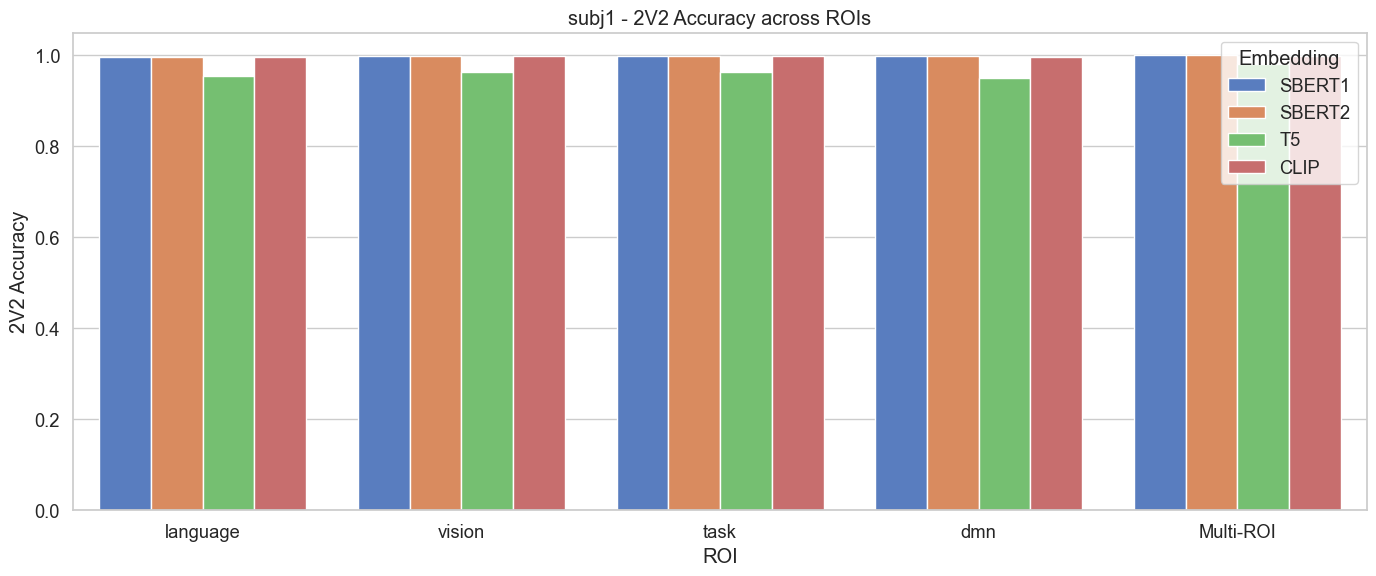

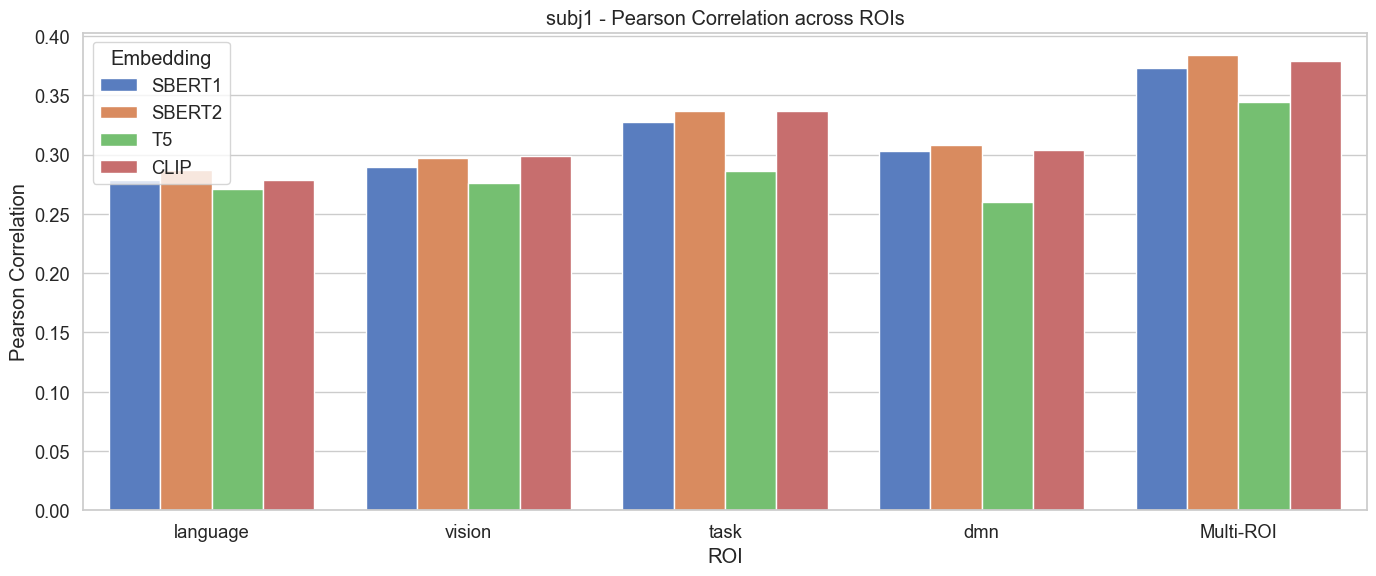

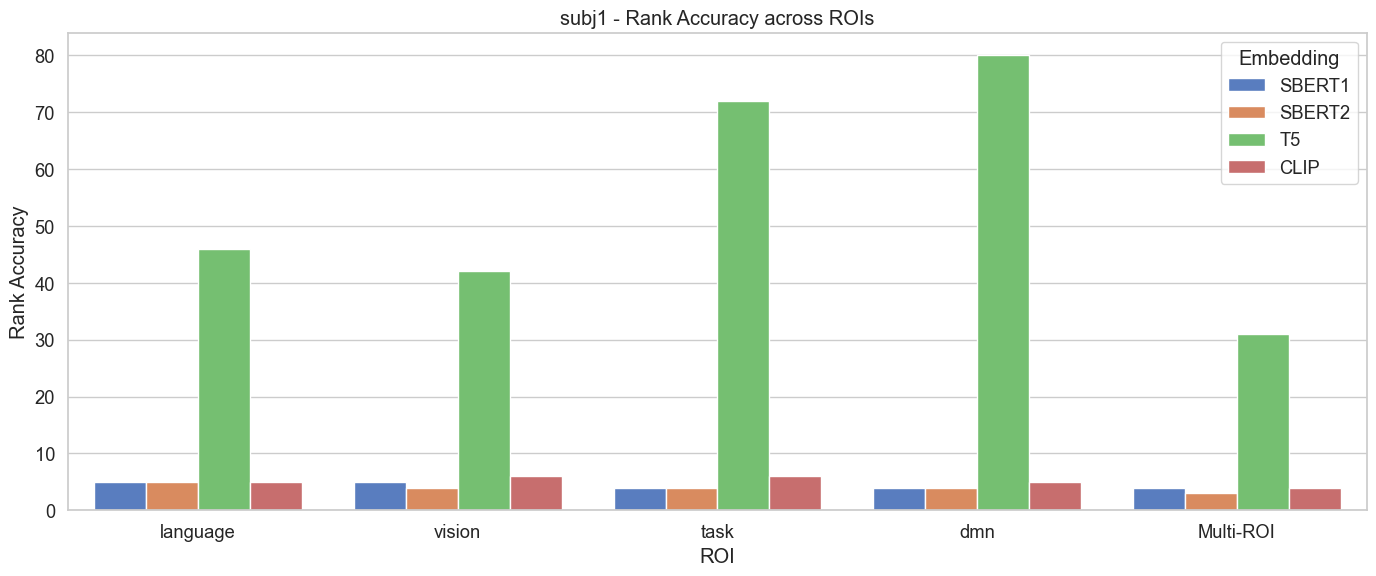

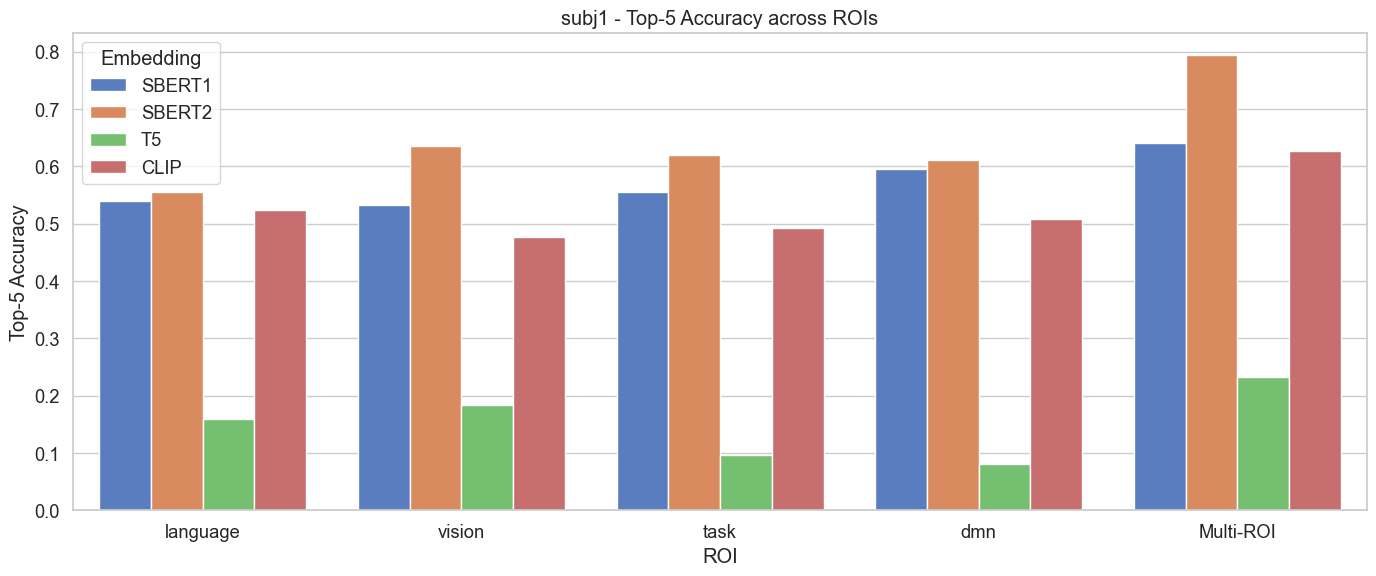

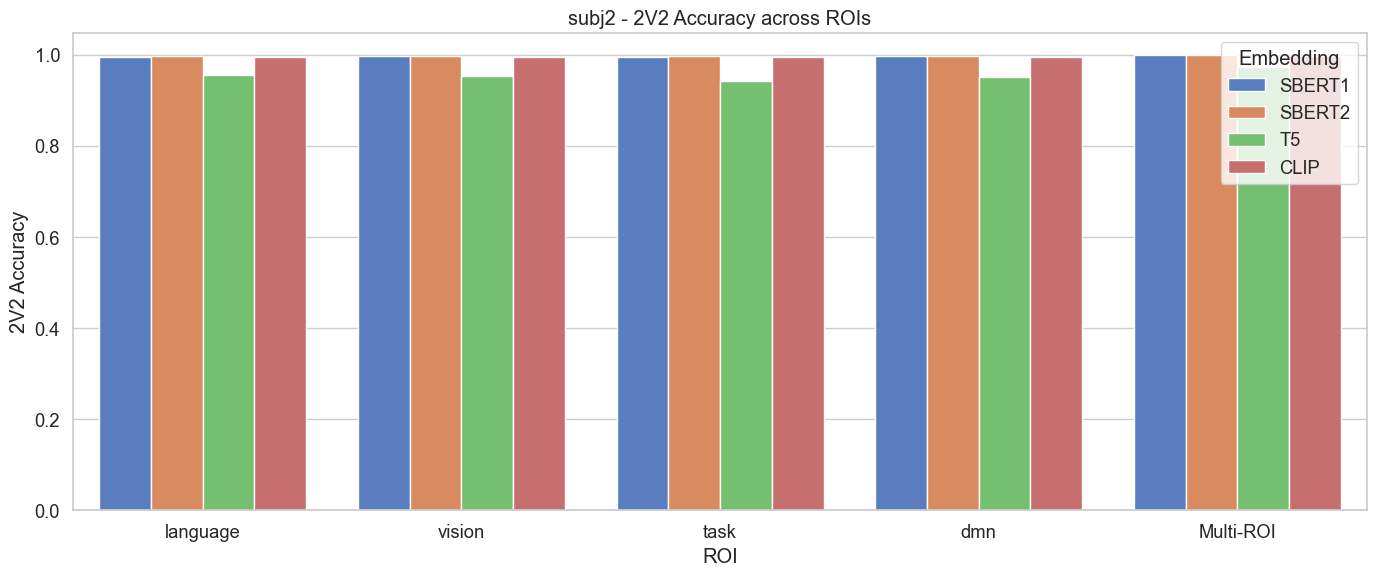

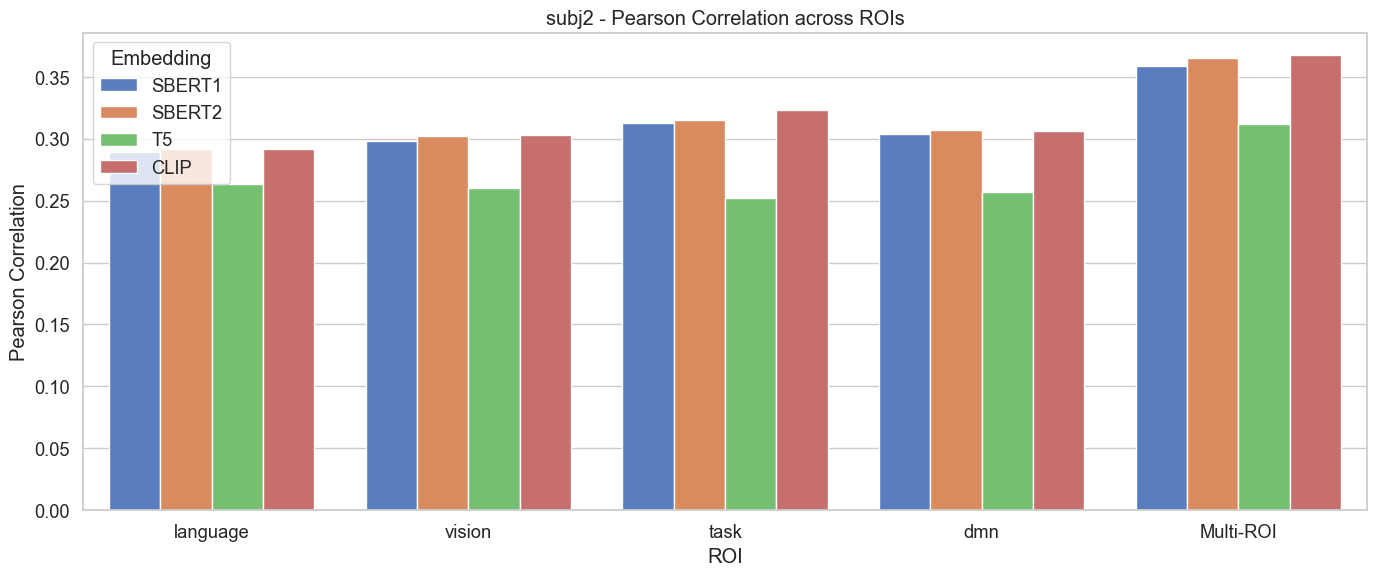

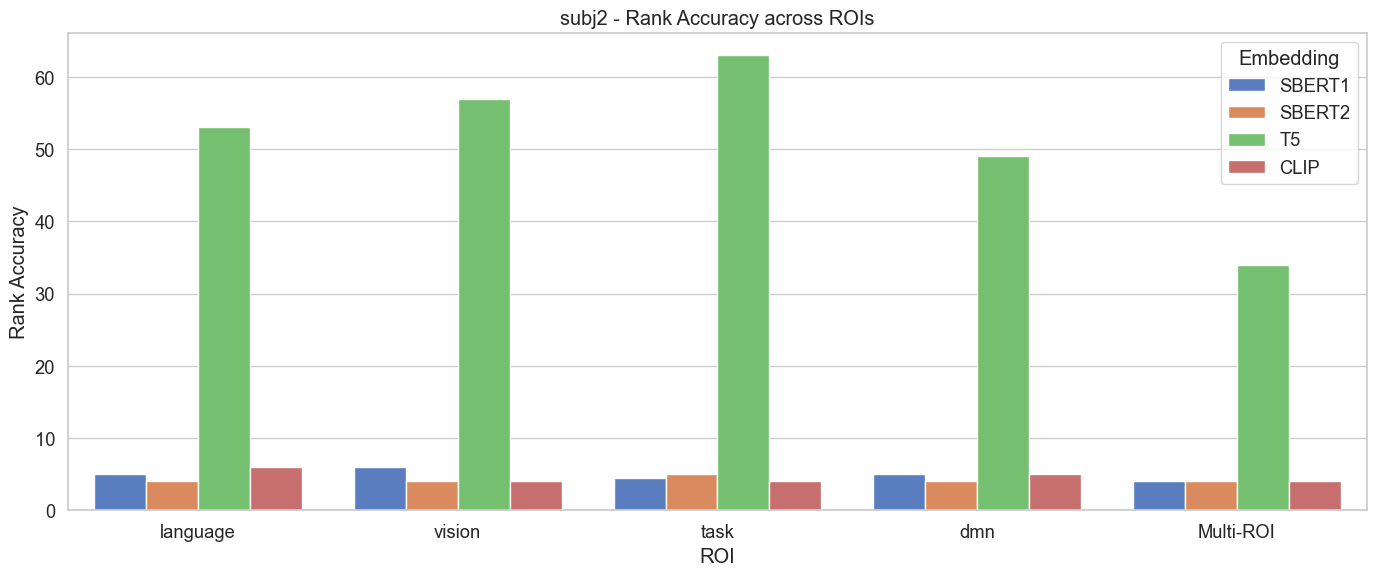

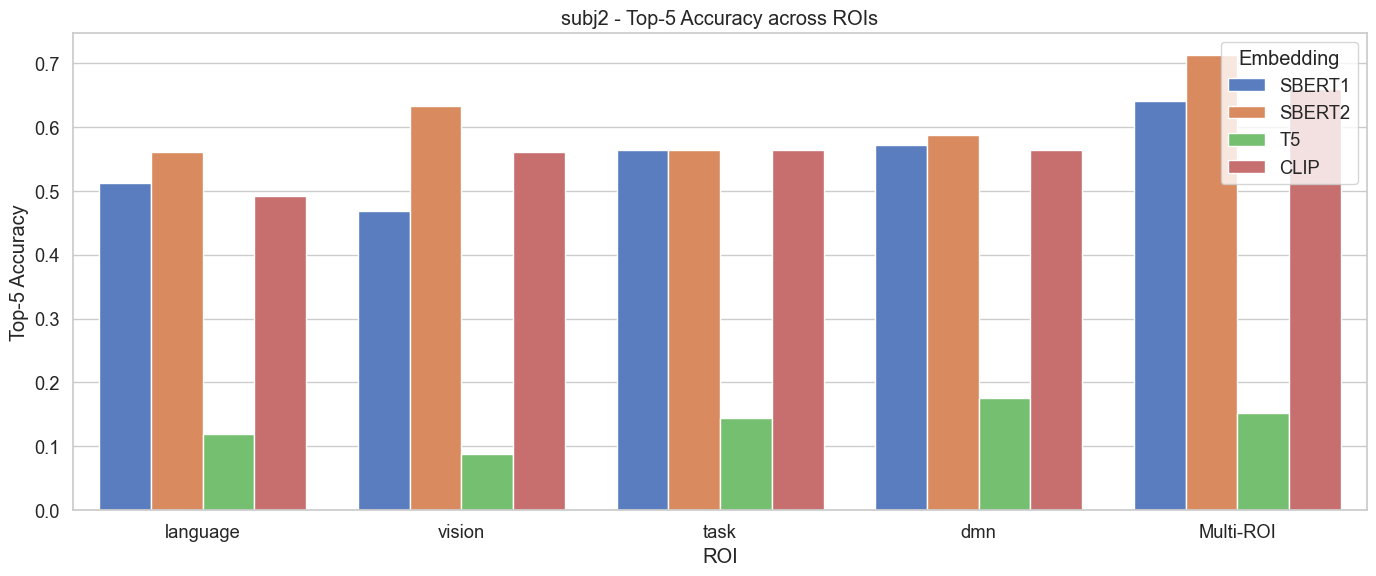

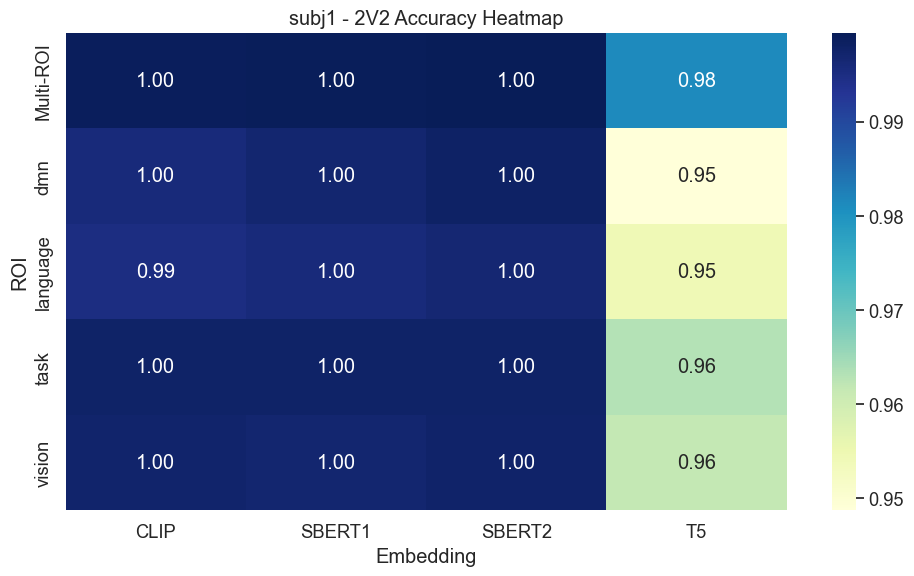

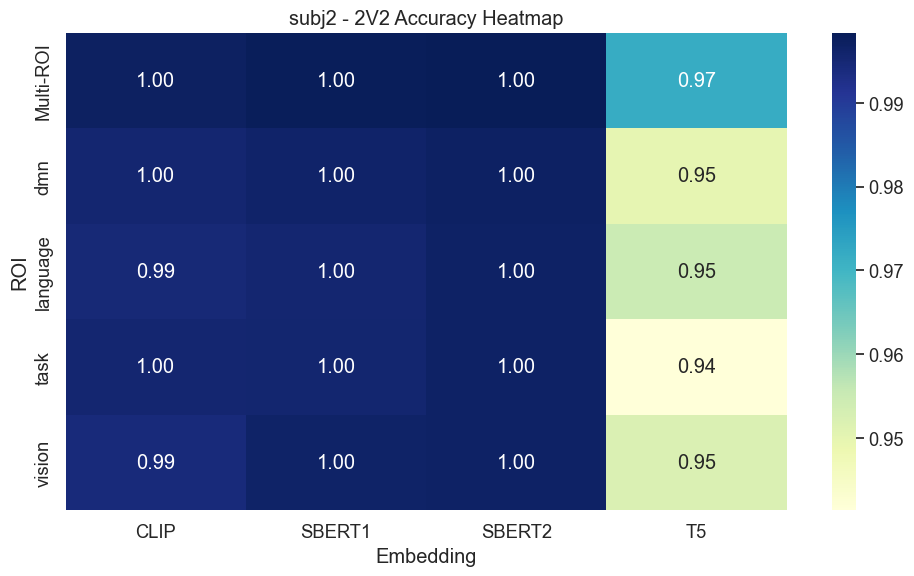

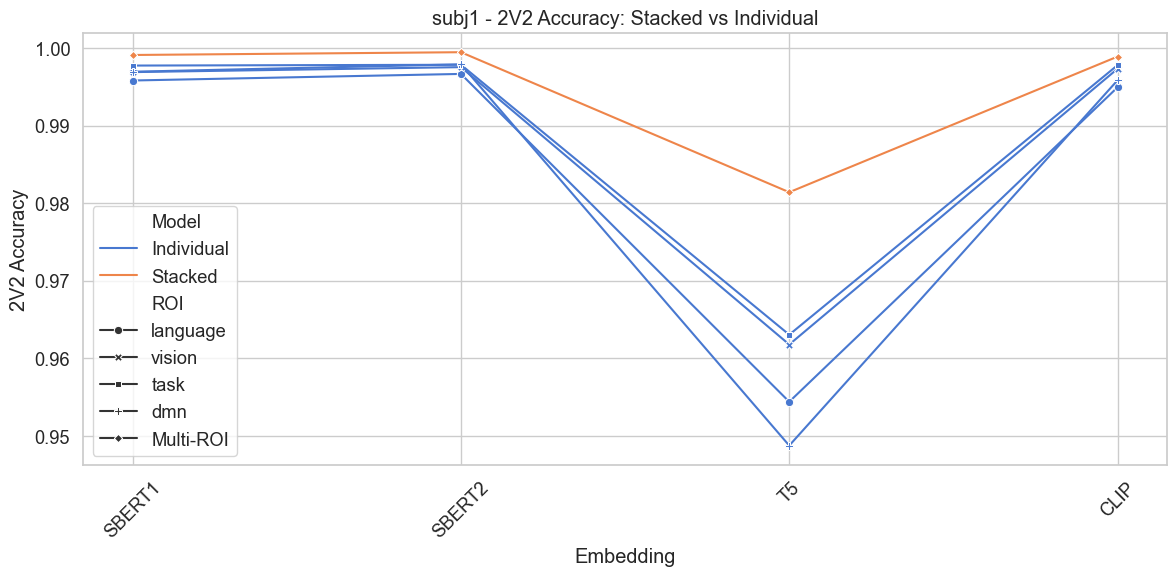

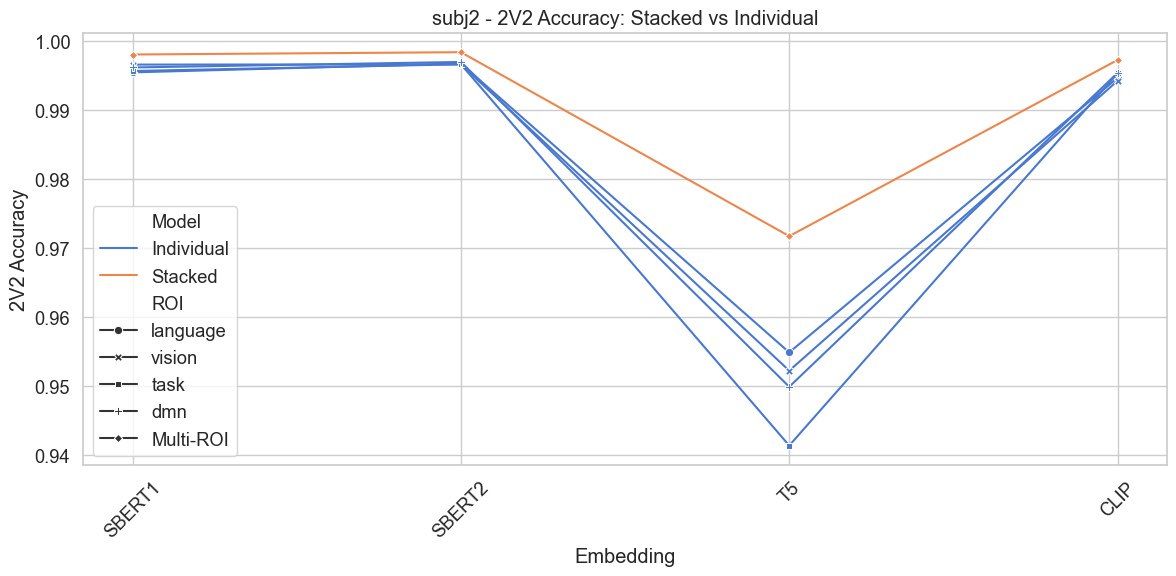

In [31]:
visualize_decoder_results(decoder_results_df)

### Key Observations from Decoder Results

- **Stacked Models**: Stacked models outperformed individual ROI-based models across both subjects, highlighting the benefits of integrating signals from multiple brain regions.

- **Embedding Performance**:
    - **SBERT2** emerged as the best-performing embedding overall, followed closely by **SBERT1** and **CLIP**.
    - **T5** showed relatively lower performance but still achieved reasonable results, particularly in rank-based metrics.

- **ROI Performance**:
    - **Language** and **Vision** ROIs consistently demonstrated better performance compared to **Task** and **DMN** (Default Mode Network) across most metrics and embeddings.

In [27]:

# Execute bonus task: text recreation
for subject_name in subjects.keys():
    for emb_name in ['SBERT2', 'T5']:  # Use best performing embeddings
        recreate_text_from_embeddings(subject_name, emb_name)

print("Brain decoder pipeline complete!")


Recreating text for subj1 using SBERT2 embeddings:
Sample 1:
  Original: An accordion is a portable musical instrument with two keyboards.
  Predicted: Accordions produce sound with bellows that blow air through reeds.
  Similarity: 0.5972

Sample 2:
  Original: Some apartments are for single people, others for families.
  Predicted: An apartment may have one or more rooms, as well as a kitchen and a bathroom.
  Similarity: 0.6161

Sample 3:
  Original: The apartment building can have a garage, a laundry facility or extra storage space.
  Predicted: An apartment may have one or more rooms, as well as a kitchen and a bathroom.
  Similarity: 0.4563

Sample 4:
  Original: Apples have thin skin, a crisp, sweet pulp and seeds inside.
  Predicted: Apples have thin skin, a crisp, sweet pulp and seeds inside.
  Similarity: 0.5179

Sample 5:
  Original: Apples can be eaten raw, roasted or baked in pies.
  Predicted: Freshly squeezed orange juice often contains pulp as well.
  Similarity: 0.526